### IMPORTANDO AS BIBLIOTECAS

In [1]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

### LEITURA DA BASE DE DADOS

In [2]:
df = pd.read_parquet("../data/processed/sim_2006_2019_balanced.parquet") 

### VISUALIZAÇÃO DA BASE DE DADOS

In [16]:
df['SUICIDIO'].value_counts()

SUICIDIO
0    136073
1    136073
Name: count, dtype: int64

### BALANCEAMENTO DA BASE DE DADOS EM CASOS DE SUICÍDIO

In [4]:
suicidio_0 = df[df['SUICIDIO'] == 0]
suicidio_1 = df[df['SUICIDIO'] == 1]

suicidio_0_sample = suicidio_0.sample(n=len(suicidio_1), replace=False)

balanced_df = pd.concat([suicidio_0_sample, suicidio_1], ignore_index=True).reset_index(drop=True)

#### Definindo X e Y de acordo com a base de dados balanceada

In [5]:
X = balanced_df[['ESC', 'ESTCIV', 'IDADE' ,	'NATURAL' ,	'OCUP',	'RACACOR'	,'MASCULINO',	'FEMININO'	]].values
Y = balanced_df['SUICIDIO'].values

#### Divisão entre teste e treino 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=666)

### TREINANDO O MODELO
Modelo escolhido: Centróides.
Como nossa base de dados já apresenta os dados de suicídio, não foi necessária a clusterização. Portanto, os centróides de clusters podem ser utilizados para identificar os pontos centrais. Cada centróide representa os aspectos gerais de uma determinada classe.

In [7]:
modelo_prototipos = NearestCentroid()

In [8]:
modelo_prototipos.fit(X_train, y_train)

NearestCentroid()

### PREVISÃO DO MODELO TREINADO E ACURÁCIA

In [9]:
y_pred = modelo_prototipos.predict(X_test)

In [10]:
relatorio = classification_report(y_test, y_pred)
matriz = confusion_matrix(y_test, y_pred)

In [11]:
print("Relatório de Classificação:\n", relatorio)
print("Matriz de Confusão:\n", matriz)

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.61      0.40      0.49     27062
           1       0.56      0.75      0.64     27368

    accuracy                           0.58     54430
   macro avg       0.58      0.57      0.56     54430
weighted avg       0.58      0.58      0.56     54430

Matriz de Confusão:
 [[10930 16132]
 [ 6963 20405]]


### VISUALIZAÇÃO DOS DADOS

/mnt/c/Users/arthu/Desktop/Grupo/Aprendizado de Maquina/Apoio-vida/apoio-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/c/Users/arthu/Desktop/Grupo/Aprendizado de Maquina/Apoio-vida/apoio-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/c/Users/arthu/Desktop/Grupo/Aprendizado de Maquina/Apoio-vida/apoio-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_

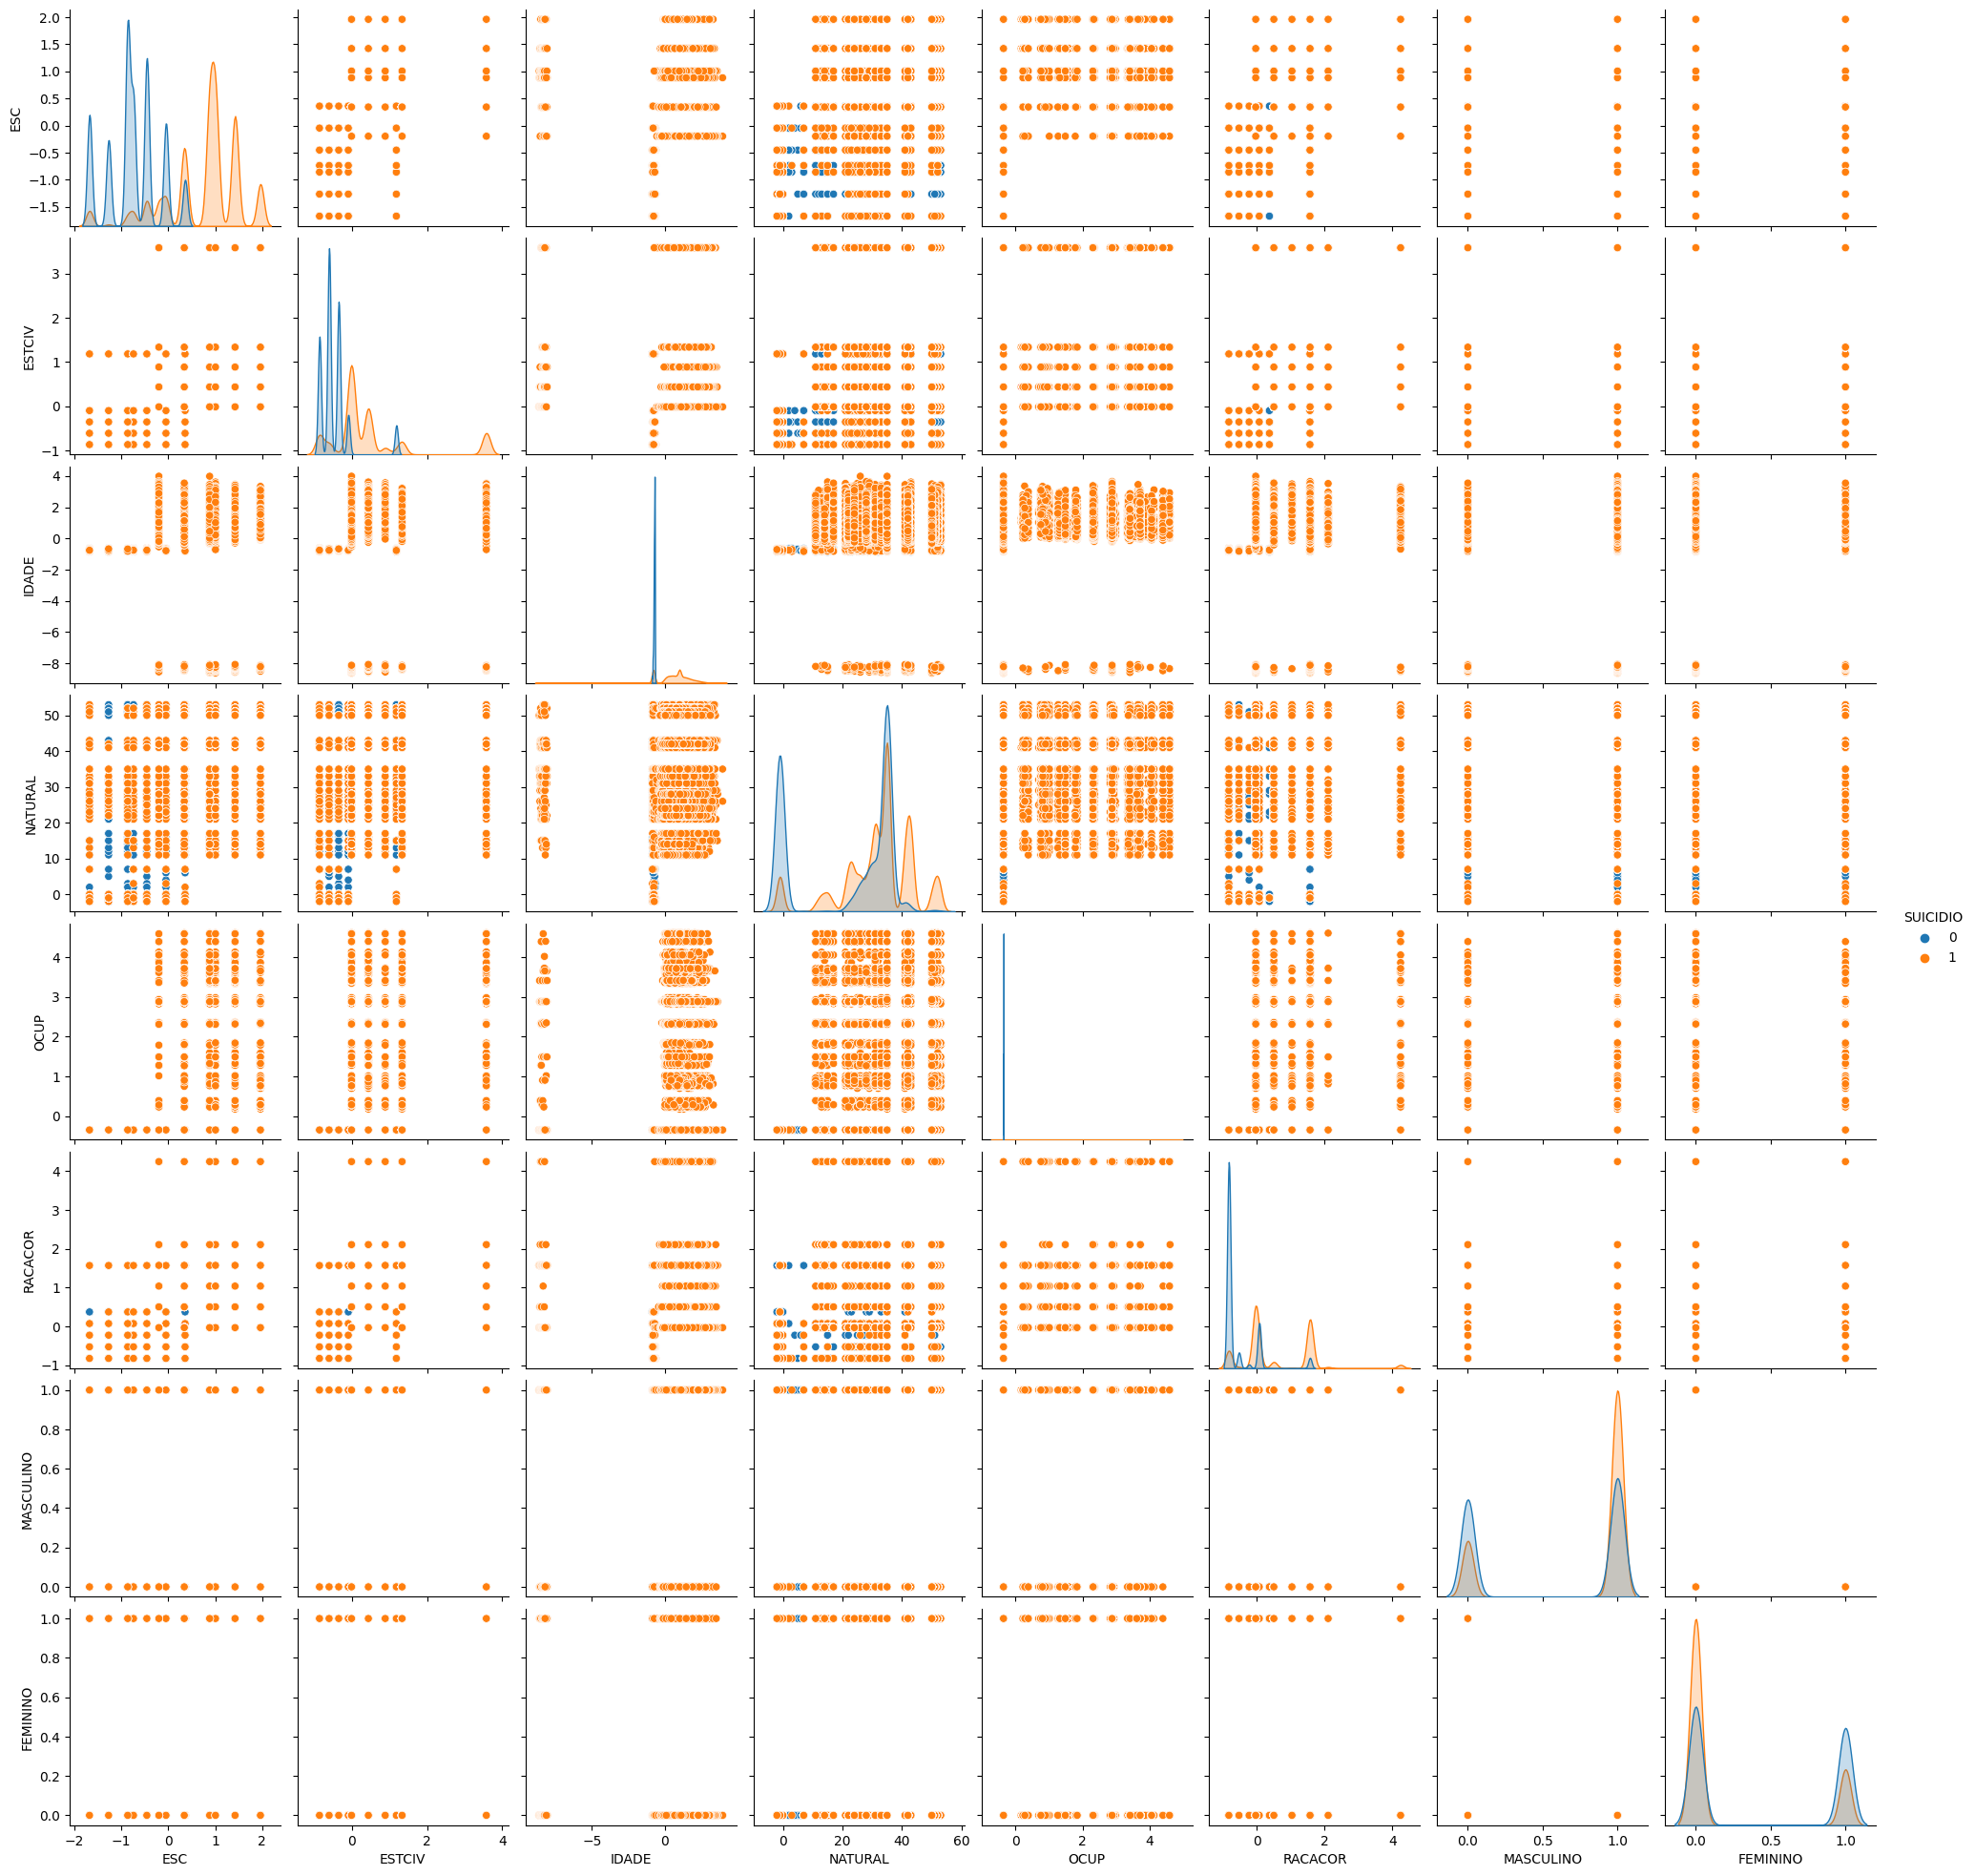

In [12]:
import seaborn as sns

# Plotar gráficos de distribuição das features em relação à variável alvo
sns.pairplot(balanced_df, hue='SUICIDIO', vars=['ESC', 'ESTCIV', 'IDADE', 'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO'])

In [71]:
geovanna = pd.DataFrame({'ESC': 5,    'ESTCIV': 1,    'IDADE': 22,    'NATURAL': 53,    'OCUP': -1,    'RACACOR': 4,    'MASCULINO': False,    'FEMININO': True}, index=[0])

arthur = pd.DataFrame({'ESC': 5,    'ESTCIV': 1,    'IDADE': 21,    'NATURAL': 52,    'OCUP': -1,    'RACACOR': 1,    'MASCULINO': True,    'FEMININO': False}, index=[0])



doug = pd.DataFrame({'ESC': 4,    'ESTCIV': 2,    'IDADE': 34,    'NATURAL': 29,    'OCUP': 5132,    'RACACOR': 4,    'MASCULINO': True,    'FEMININO': False}, index=[0])



cozinheiro = pd.DataFrame({'ESC': 4,    'ESTCIV': 2,    'IDADE': 34,    'NATURAL': 29,    'OCUP': 5132,    'RACACOR': 4,    'MASCULINO': True,    'FEMININO': False}, index=[0])


In [72]:
teste = pd.concat((geovanna, arthur, doug, cozinheiro), ignore_index=True)

std = StandardScaler()
columns = ['ESC', 'ESTCIV', 'IDADE', 'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])
x = teste[['ESC', 'ESTCIV', 'IDADE', 'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']].values

In [73]:
y_pred = modelo_prototipos.predict(x)
y_pred


array([1, 1, 1, 1])